In [94]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [95]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [58]:
df = pd.read_csv('/Users/anshugangwar/Desktop/Anshu/Data Science Portfolio/ML Micro Projects/data/raw/daily-total-female-births-CA.csv', index_col=['date'], parse_dates=['date'])

In [59]:
df

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [61]:
df.describe()

,births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


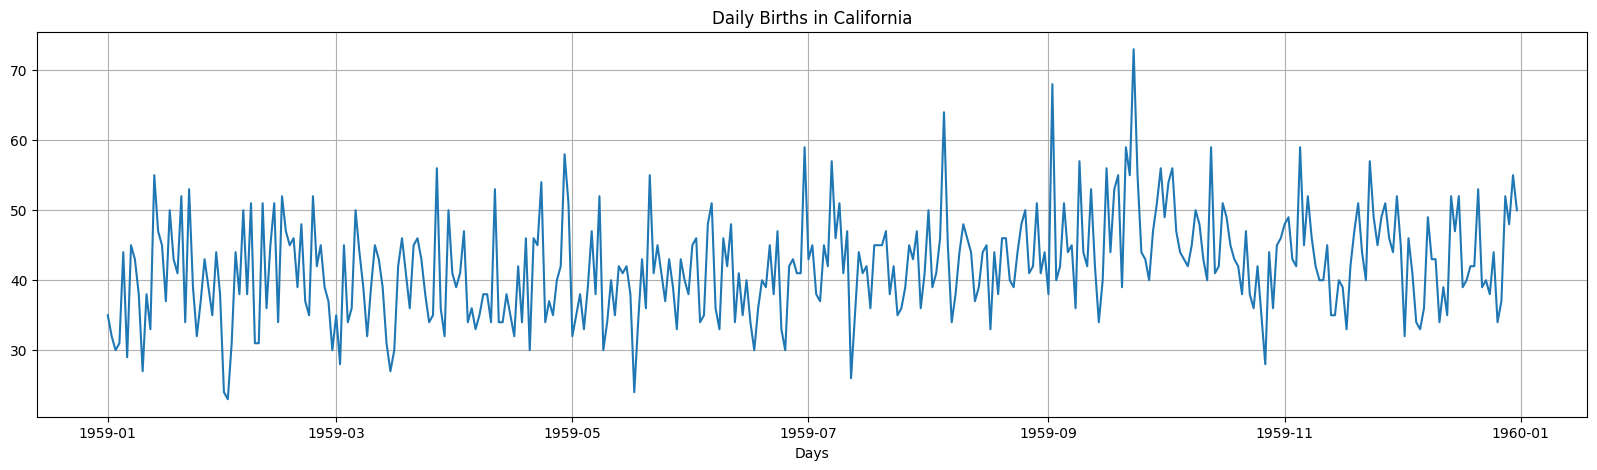

In [62]:
plt.figure(figsize=(20,5))
plt.plot(df['births'])
plt.title('Daily Births in California')
plt.xlabel('Days')
plt.grid(True)
plt.show()

In [63]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df, 30) # prediction for next day, using the last observed day's data.  (past 30 days)

np.float64(42.3)

In [64]:
def plotMovingAverage(series, window, plot_intervals = False, scale= 1.96, plot_anomalies = False):
    """
        series - time series data
        window - window size for moving average
        plot_intervals - whether to plot confidence intervals
        plot_anomalies - whether to plot anomalies
        scale - scale for confidence intervals
    """
    rolling_mean = series.rolling(window= window).mean()
    plt.figure(figsize= (20,5))
    plt.title("Moving Average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label= "Rolling Mean Trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label= "Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


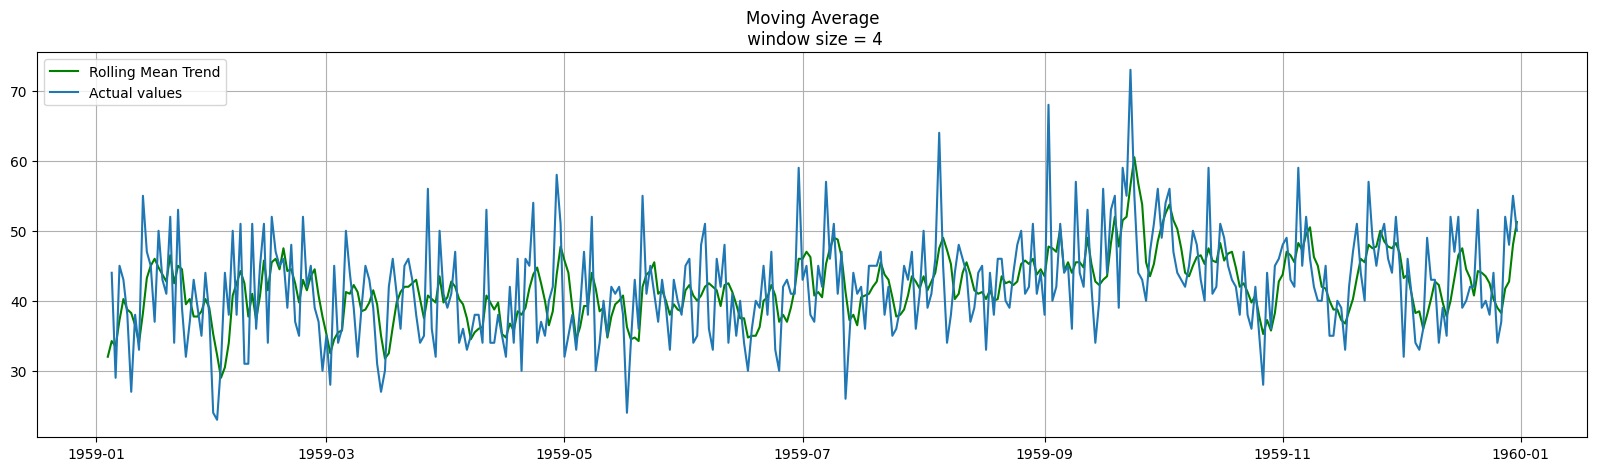

In [65]:
plotMovingAverage(df, 4)

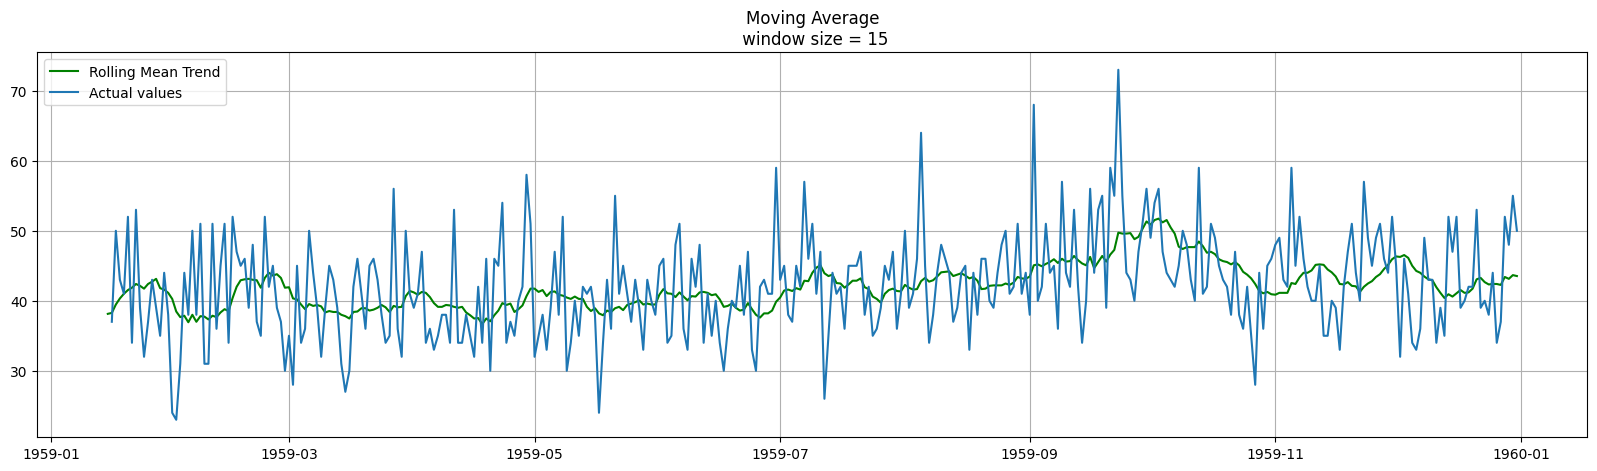

In [66]:
plotMovingAverage(df, 15)

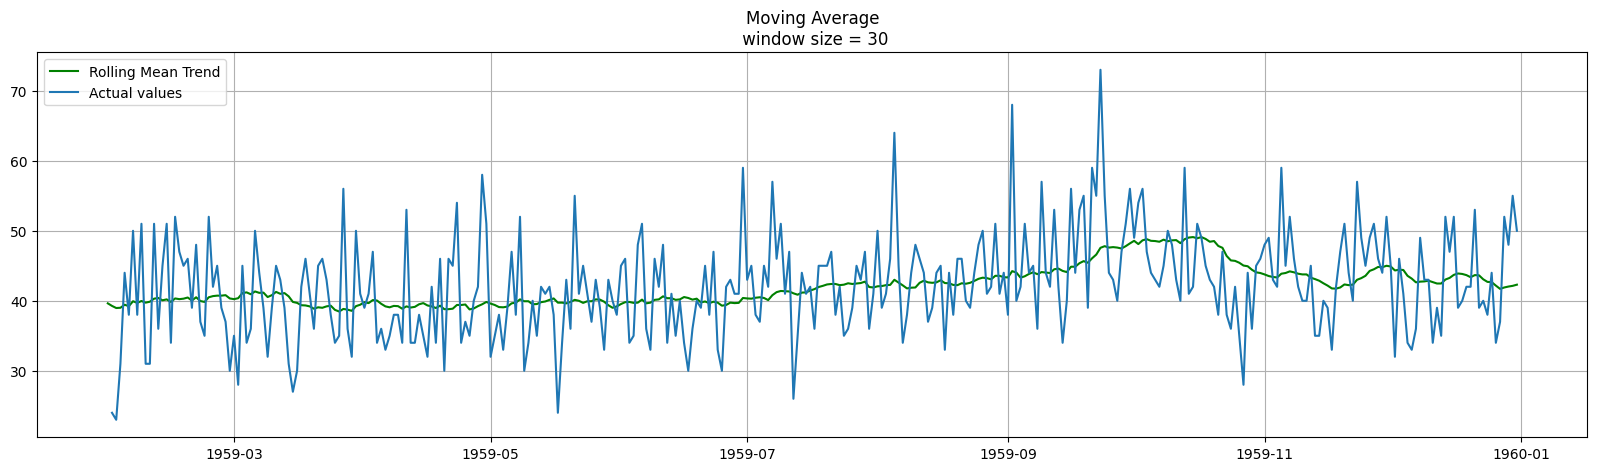

In [67]:
plotMovingAverage(df, 30)

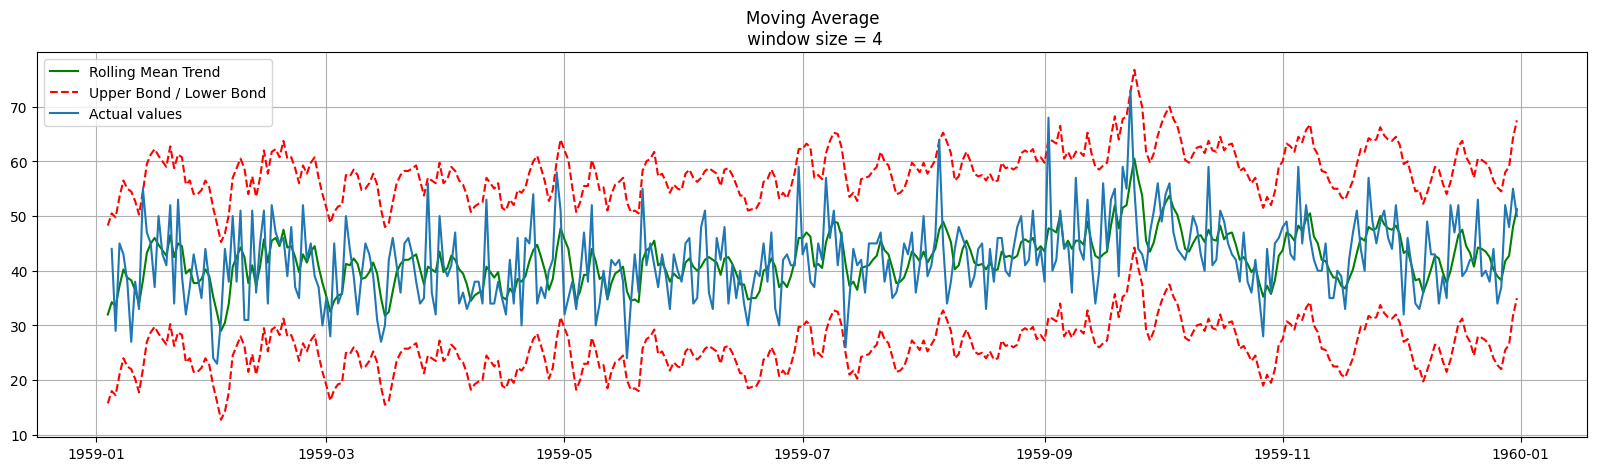

In [68]:
plotMovingAverage(df, 4, plot_intervals = True)

### **Weighted average** is a simple modification to the moving average. The weights sum up to `1` with larger weights assigned to more recent observations.


## $\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [69]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [70]:
weighted_average(df, [0.6, 0.3, 0.1])

51.3

# Exponential smoothing

### Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

## $$\hat{y}_{t+1} = \alpha \cdot y_t + \alpha(1-\alpha) \cdot y_{t-1} +\alpha  (1-\alpha)^2 \cdot y_{t-2} + +\alpha  (1-\alpha)^3 \cdot y_{t-3} +... $$

## $$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t} $$

### Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

### Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [71]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [85]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-v0_8-whitegrid'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

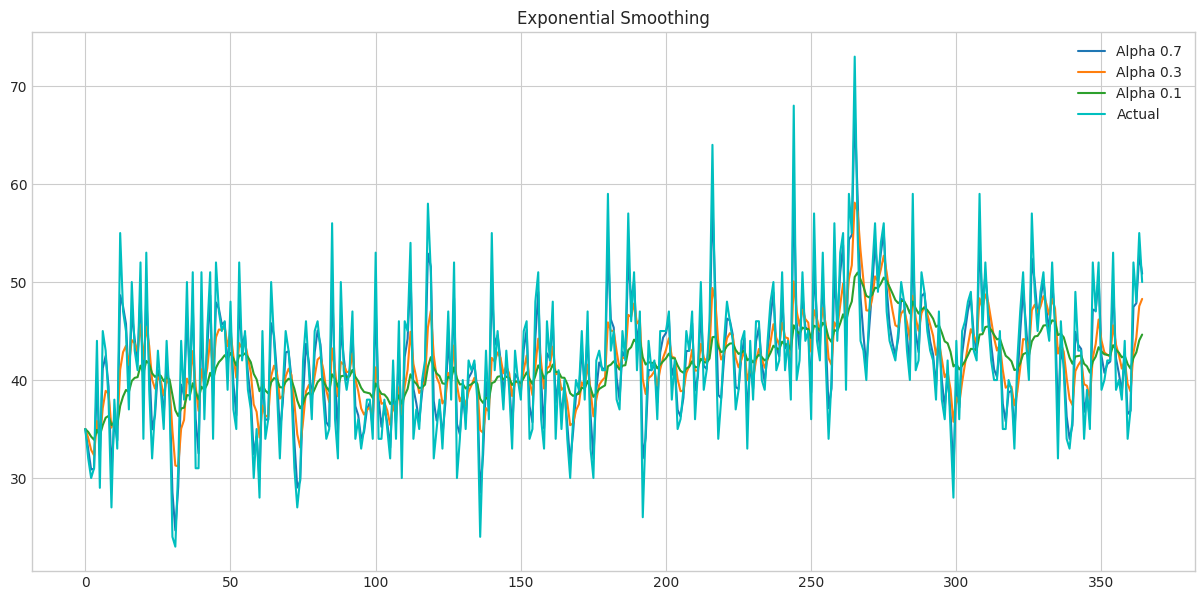

In [86]:
plotExponentialSmoothing(df.births, [0.7,0.3, 0.1])

# Double exponential smoothing (Holt’s linear trend method)

### Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough.

Holt (1957) extended simple exponential smoothing to allow the forecasting of data with a trend. This method involves a forecast equation and two smoothing equations (one for the level and one for the trend):

### Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes.


As a result, we get the following set of functions:

##$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

## $$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

## $$\hat{y}_{x+1} = \ell_x + b_x$$

### The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [87]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context('seaborn-v0_8-whitegrid'):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

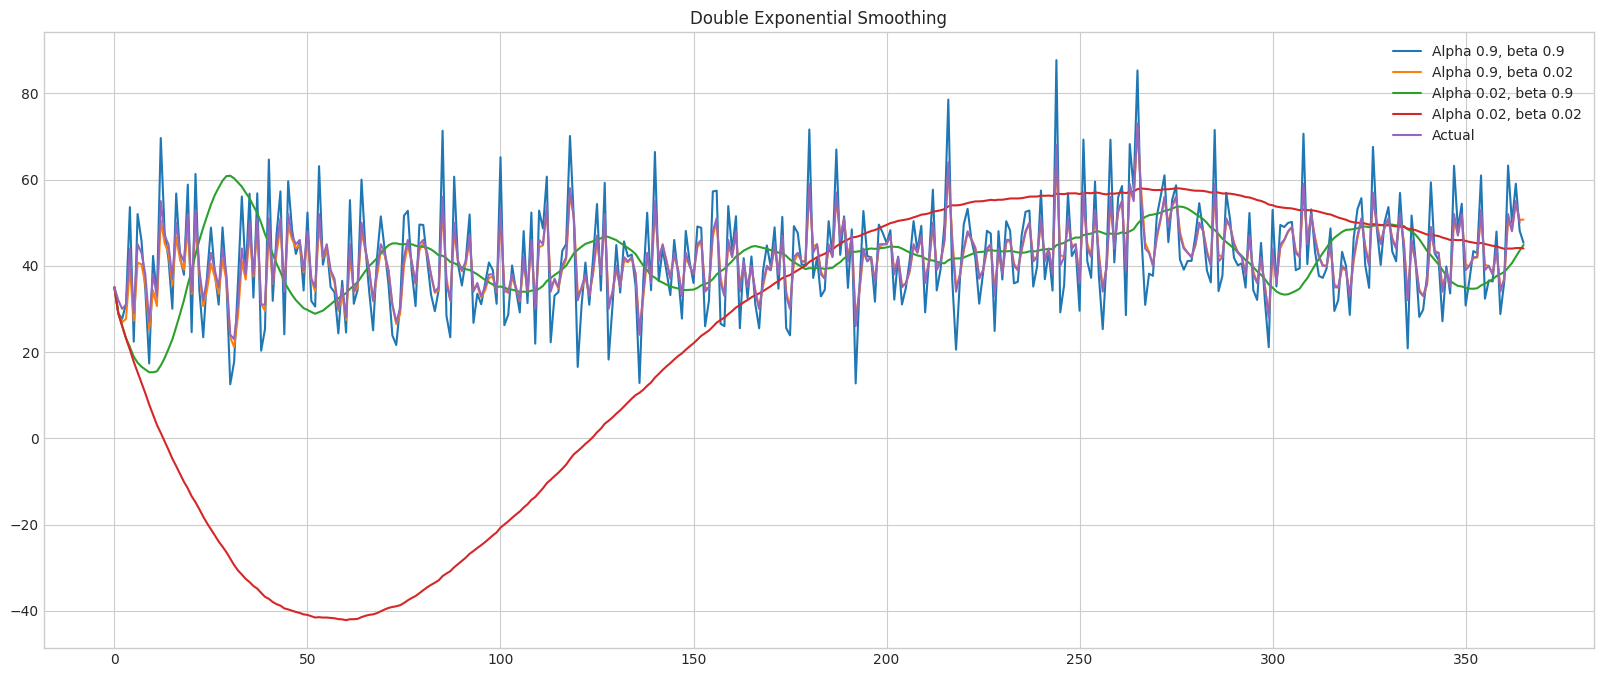

In [88]:
plotDoubleExponentialSmoothing(df.births, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# Econometric approach

## <b>Stationarity </b>

### Before we start modeling, we should mention such an important property of time series: [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process).

### If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations.


## White noise chart:

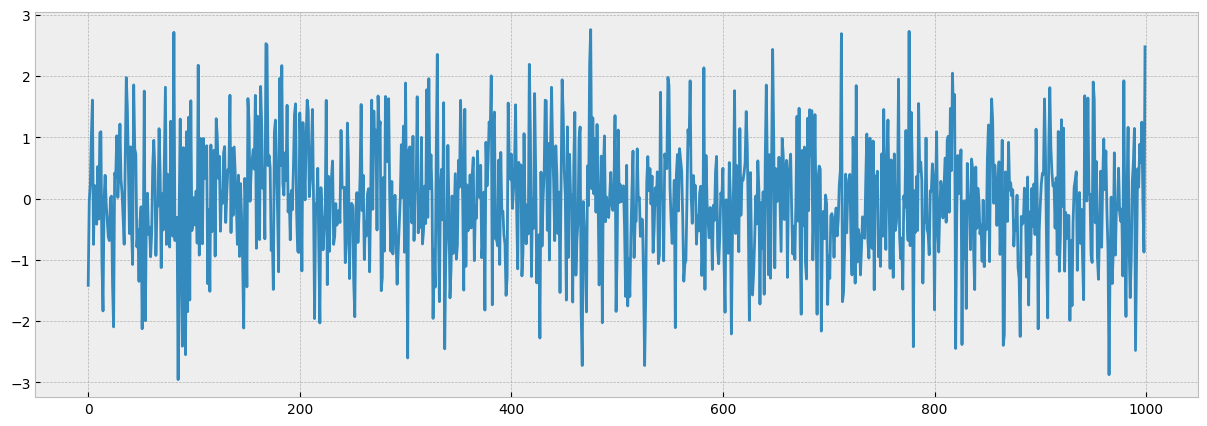

In [90]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

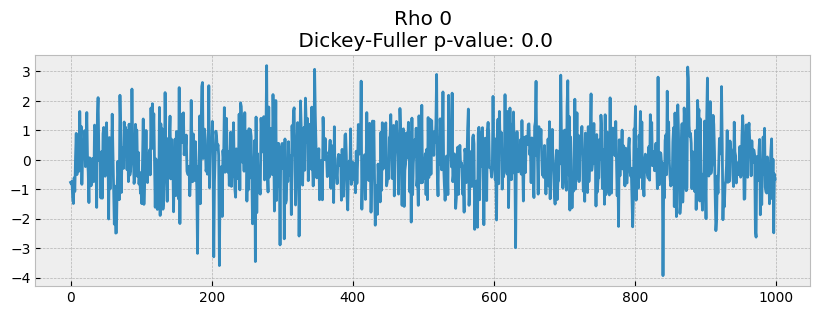

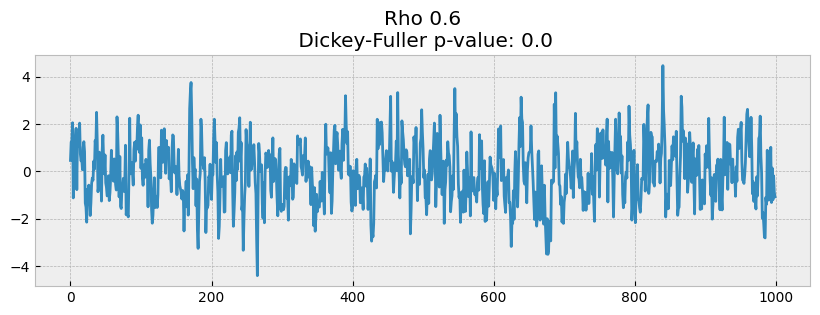

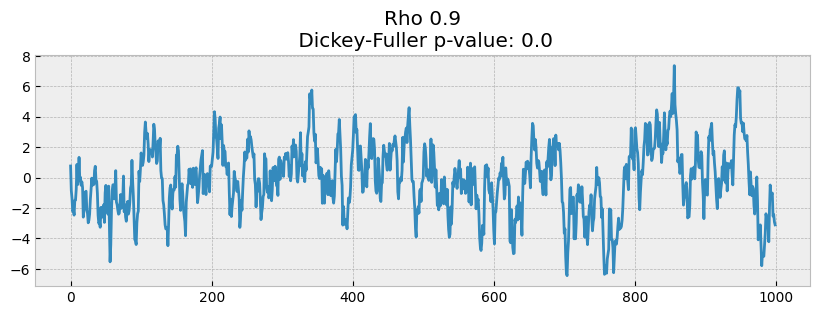

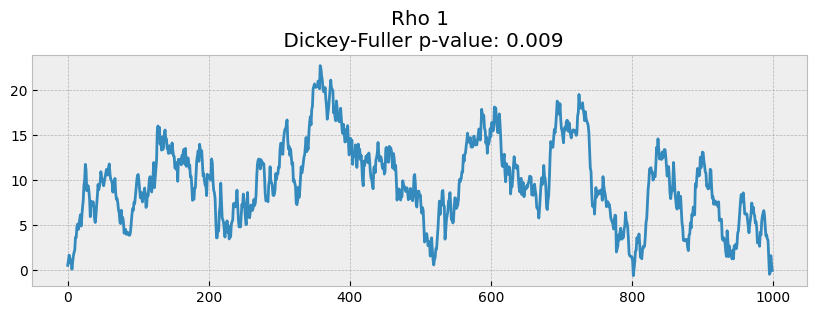

In [96]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)